In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
import FinanceDataReader as fdr


from IPython.display import set_matplotlib_formats
import matplotlib as mpl
mpl.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
mpl.rc('axes',unicode_minus = False)
from PIL import Image
from collections import Counter
from wordcloud import WordCloud
from ekonlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
mecab = Mecab()


import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from nltk.tokenize import sent_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFGPT2LMHeadModel


from sklearn.model_selection import train_test_split
from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [2]:
path = '/Users/ps712/OneDrive/ps/aibi/snsstock/'
path2='/Users/ps712/OneDrive/ps/aibi/snsstock/newsdata/'
list_name = 'stock.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목,종목코드
0,삼성전자,005930
1,카카오,035720
2,위메이드,112040
3,현대차,005380
4,SK하이닉스,000660
5,카카오뱅크,323410
6,한국조선해양,009540
7,ARIRANG 고배당주,161510
8,NAVER,035420
9,셀트리온,068270


In [3]:
stockcode = stock_list.loc[1,'종목코드']
news= pd.read_csv(os.path.join(path2,stockcode))
print(len(news))

5462


In [4]:
news['날짜'] = pd.to_datetime(news['날짜'])
news['year'] =news['날짜'].dt.year
news['month'] =news['날짜'].dt.month
news['day'] =news['날짜'].dt.day
news['time'] =news['날짜'].dt.time
news['date'] =news['날짜'].dt.date
news['hour'] =news['날짜'].dt.hour
news['week_day'] =news['날짜'].dt.day_name()
news['week_day_num'] =news['날짜'].dt.dayofweek
news.drop(['Unnamed: 0'],axis=1,inplace=True)
mask=news['hour']<=15 #16시 이전 뉴스만 추출
dayofend=[5,6]
weekends= news.query('week_day_num in @dayofend')
weekday= news.query('week_day_num not in @dayofend')
news = weekday.loc[mask]
news = news.loc[news['year']==2021]
news.index = pd.to_datetime(news['date'])

In [5]:
news.drop(['week_day_num'],axis=1,inplace=True)

print(len(news))

3509


In [6]:
news.drop_duplicates(subset=['기사제목'],inplace=True)
print(len(news))

2269


In [7]:
news

,날짜,언론사,기사제목,링크,year,month,day,time,date,hour,week_day
date,,,,,,,,,,,
2021-12-29,2021-12-29 15:43:00,한국경제,"""구조대 대체 언제 오나요""…카카오 올라탄 개미들 '눈물'",https://finance.naver.com/item/news_read.naver...,2021,12,29,15:43:00,2021-12-29,15,Wednesday
2021-12-29,2021-12-29 12:36:00,이데일리,"카카오, 올해 AI 논문 40건 등재…“글로벌 AI 리더십 선도”",https://finance.naver.com/item/news_read.naver...,2021,12,29,12:36:00,2021-12-29,12,Wednesday
2021-12-29,2021-12-29 10:00:00,파이낸셜뉴스,"카카오, 올해 글로벌 학회 25곳에서 AI 논문 40건 등재",https://finance.naver.com/item/news_read.naver...,2021,12,29,10:00:00,2021-12-29,10,Wednesday
2021-12-29,2021-12-29 09:56:00,서울경제,카카오 AI 세계로 간다···올해 AI 논문 총 40건 글로벌 학회에...,https://finance.naver.com/item/news_read.naver...,2021,12,29,09:56:00,2021-12-29,9,Wednesday
2021-12-28,2021-12-28 15:36:00,한국경제,카카오에서 탄생한 '바이브컴퍼니'…디지털트윈 넘어 테크핀까지,https://finance.naver.com/item/news_read.naver...,2021,12,28,15:36:00,2021-12-28,15,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-20,2021-01-20 06:30:00,파이낸셜뉴스,"[1일IT템]네이버-카카오, 올해 실적견인차는 ‘락인 전략’",https://finance.naver.com/item/news_read.naver...,2021,1,20,06:30:00,2021-01-20,6,Wednesday
2021-01-20,2021-01-20 06:10:00,서울경제,네이버·카카오·쿠팡···3사 3色 라이브 커머스 전쟁,https://finance.naver.com/item/news_read.naver...,2021,1,20,06:10:00,2021-01-20,6,Wednesday
2021-01-19,2021-01-19 10:16:00,이데일리,"라온피플, 카카오VX 골프센서 공급재개…“수주물량 대폭 확대”",https://finance.naver.com/item/news_read.naver...,2021,1,19,10:16:00,2021-01-19,10,Tuesday


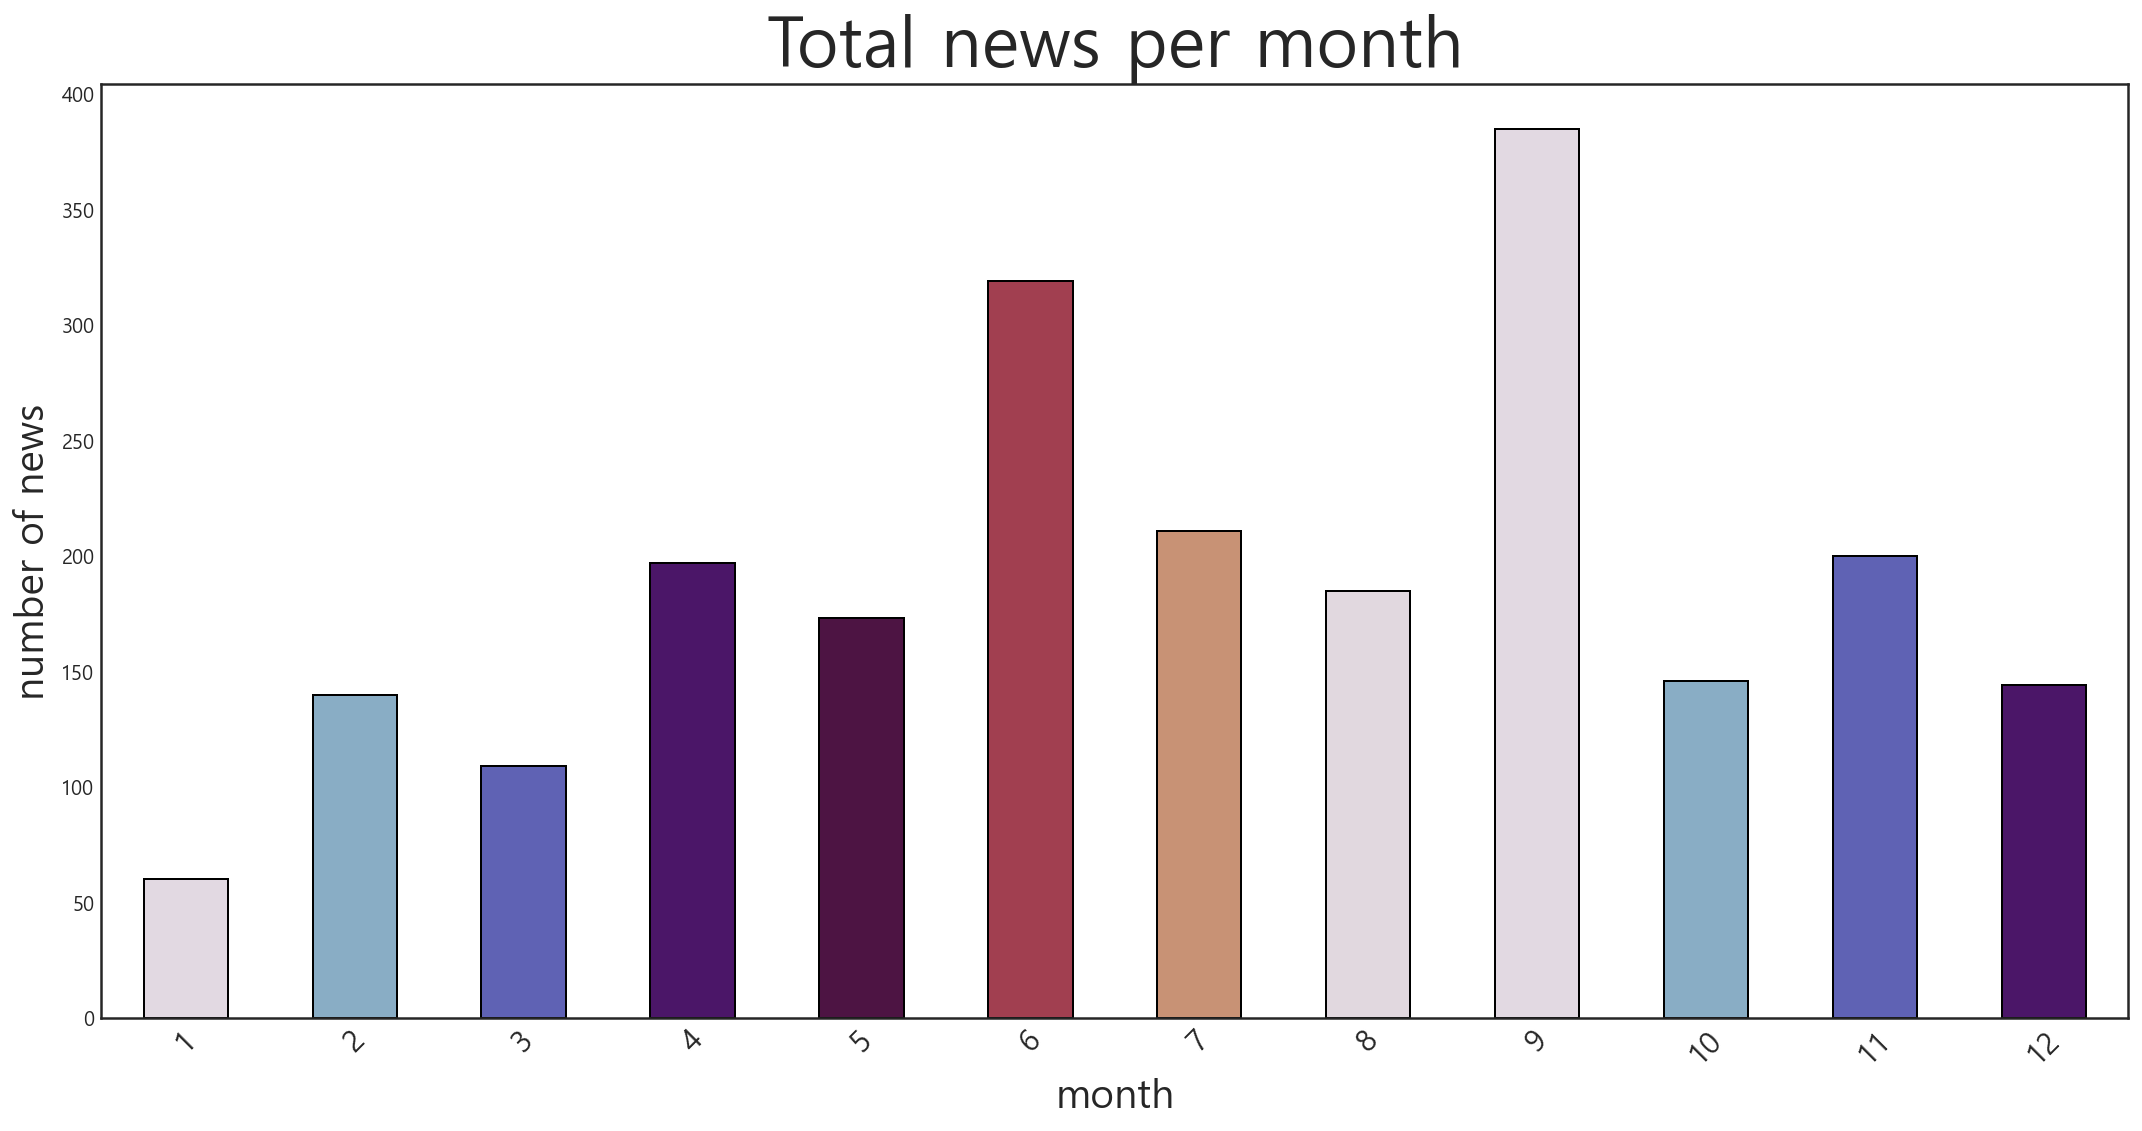

In [8]:
month_table = news['month'].value_counts()
month_table = month_table.reindex([1,2,3,4,5,6,7,8, 9, 10, 11, 12])
color_map = plt.get_cmap('twilight')
color_list = [color_map.colors[i] for i in range(0, 512, 72)]
month_table.plot(kind='bar',x='month',y='count',figsize=(15,8),edgecolor='black', color=color_list)
plt.xticks(rotation=45, fontsize=15)
plt.title('Total news per month', fontsize=35)
plt.xlabel('month', fontsize=20)
plt.ylabel('number of news', fontsize=20)
plt.tight_layout()
plt.show()

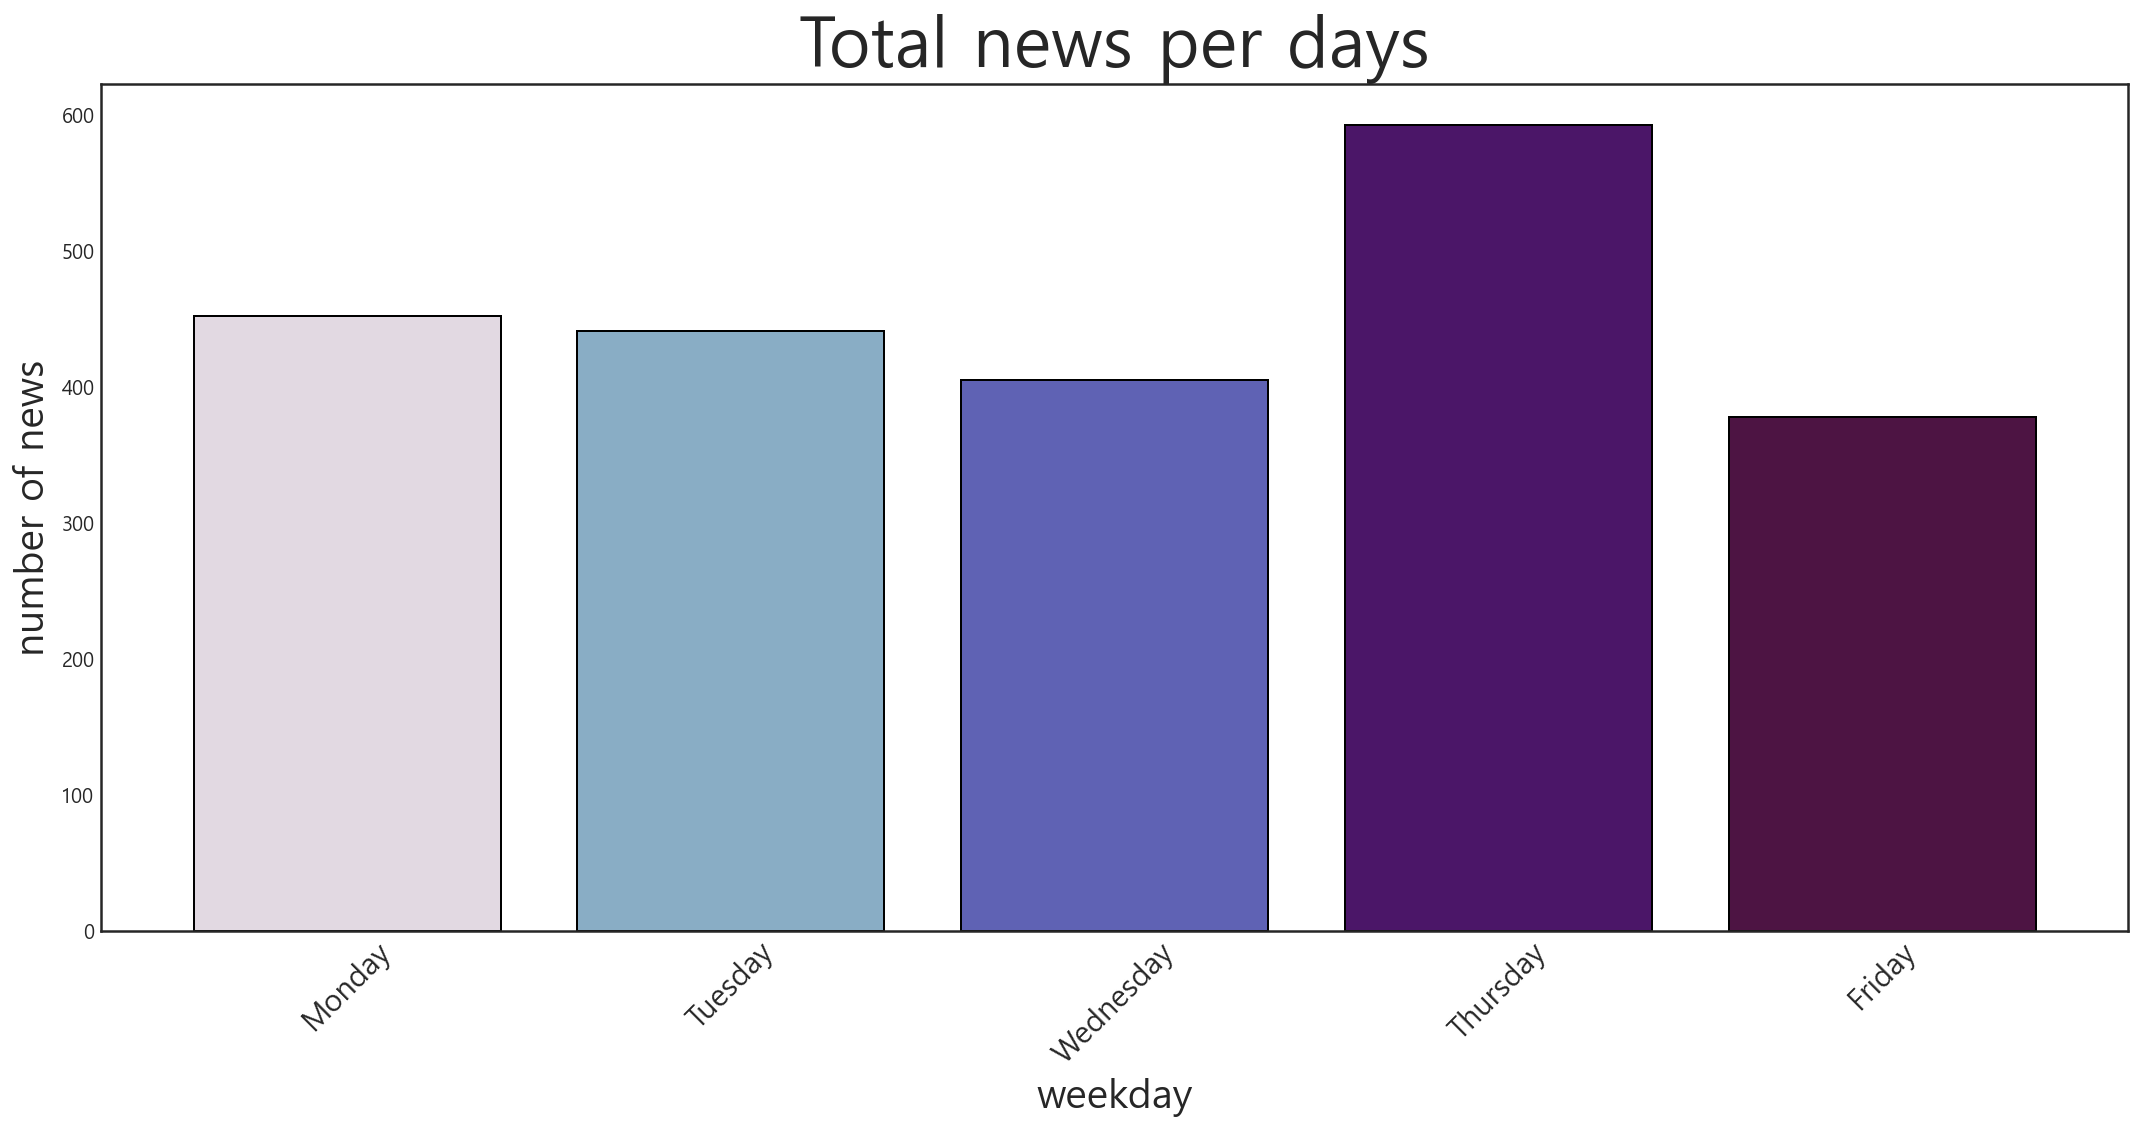

In [9]:
day_table = news['week_day'].value_counts()
day_table = day_table.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(15, 8))
color_map = plt.get_cmap('twilight')
color_list = [color_map.colors[i] for i in range(0, 512, 72)]
plt.bar(day_table.index, day_table, edgecolor='black', color=color_list)
plt.xticks(rotation=45, fontsize=15)
plt.title('Total news per days', fontsize=35)
plt.xlabel('weekday', fontsize=20)
plt.ylabel('number of news', fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
start_date = str(int(news[-1:]['날짜'].dt.strftime('%Y%m%d')))
end_date = str(int(news[0:1]['날짜'].dt.strftime('%Y%m%d')))
stock = fdr.DataReader(stockcode, start = start_date, end = end_date)
stock['up_down'] = np.where(stock['Change']>0, 1, 0)

In [11]:
news = pd.merge(news,stock['up_down'],left_index=True,right_index=True)

In [12]:
analysis = news[['기사제목','up_down']]
analysis

,기사제목,up_down
2021-01-19,"라온피플, 카카오VX 골프센서 공급재개…“수주물량 대폭 확대”",1
2021-01-19,라온피플 “카카오VX 골프센서 공급재개…수주물량 확대”,1
2021-01-19,"""카카오T에도"" 잘 키운 서비스, 광고 수확 나선 카카오",1
2021-01-20,"기아차, 연일 폭등…카카오 제치고 '시총 9위' 올랐다",1
2021-01-20,"카카오, 김범수가 이끄는 ESG위원회...기업지배구조헌장 공표",1
...,...,...
2021-12-28,"[숫자로 보는 올해 증시⑥] 시총 급락 LG화학, 약진한 네이버·카카오",1
2021-12-29,"""구조대 대체 언제 오나요""…카카오 올라탄 개미들 '눈물'",1
2021-12-29,"카카오, 올해 AI 논문 40건 등재…“글로벌 AI 리더십 선도”",1
2021-12-29,"카카오, 올해 글로벌 학회 25곳에서 AI 논문 40건 등재",1


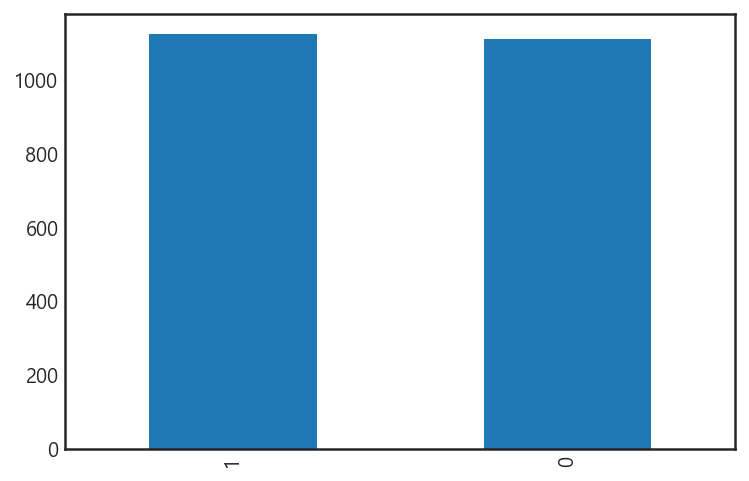

In [13]:
news['up_down'].value_counts().plot(kind='bar');#상승 하락 비슷하게 있음

In [14]:
up = news.loc[news['up_down']==1]['기사제목'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
down = news.loc[news['up_down']==0]['기사제목'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")

In [15]:
stop_words = ['첫','콜','게','두','었','더','컨','카','기','첫''게','아','적','조','네이버','카카오','삼성','삼성전자','현대','현대차','현대차그룹','기아','억','용','화','나','하','위','주','어','월','등','일','고','개','대','서','원','년','만','로','의','개사','했','다','한다','았','다','건','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
up_noun = []
for sentence in up:
    #불용어제외하고 mecab형태소분석기에 넣어줌
    up_noun.append([word for word in mecab.morphs(sentence) if not word in stop_words])

up_noun = [item for sublist in up_noun for item in sublist]           


In [16]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(up_noun)

threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0 
rara_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq = words_freq + value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq = rara_freq + value
        
print("전체 단어 수: ", words_cnt)
print("빈도가 {} 이하인 희귀 단어수 : {}".format(threshold-1, rare_cnt))
print("희귀단어비율 :{}".format((rare_cnt /words_cnt)*100))
print("희귀단어 등장빈도비율:{}".format((rare_freq / words_freq)*100))

전체 단어 수:  2468
빈도가 2 이하인 희귀 단어수 : 1757
희귀단어비율 :71.19124797406808
희귀단어 등장빈도비율:0.013287270794578792


In [17]:
nouns_counter = Counter(up_noun)
top_nouns = dict(nouns_counter.most_common(50))
top_nouns

{'모빌리티': 88,
 '시총': 71,
 '특징': 65,
 '엔터': 50,
 '상승': 49,
 '코스피': 48,
 '투자': 44,
 '택시': 42,
 '상장': 41,
 '강세': 39,
 '플랫폼': 38,
 '커머스': 33,
 '액면분할': 32,
 '최대': 31,
 '웹툰': 31,
 '주가': 29,
 '에서': 29,
 '인수': 29,
 '까지': 28,
 '실적': 27,
 '분기': 26,
 '금융': 24,
 '김범수': 23,
 '목표가': 23,
 '반등': 22,
 '규제': 22,
 '올해': 21,
 '출범': 21,
 '영업익': 21,
 '매출': 21,
 '서비스': 20,
 '장중': 20,
 '테크': 20,
 '전년': 20,
 '급등': 20,
 '매수': 20,
 '영준': 20,
 '경쟁': 19,
 '카카오페이': 19,
 '단독': 18,
 '시장': 18,
 '출시': 18,
 '선': 18,
 '사업': 18,
 '자회사': 18,
 '목표': 17,
 '글로벌': 17,
 '보': 17,
 '후': 17,
 '마켓': 17}

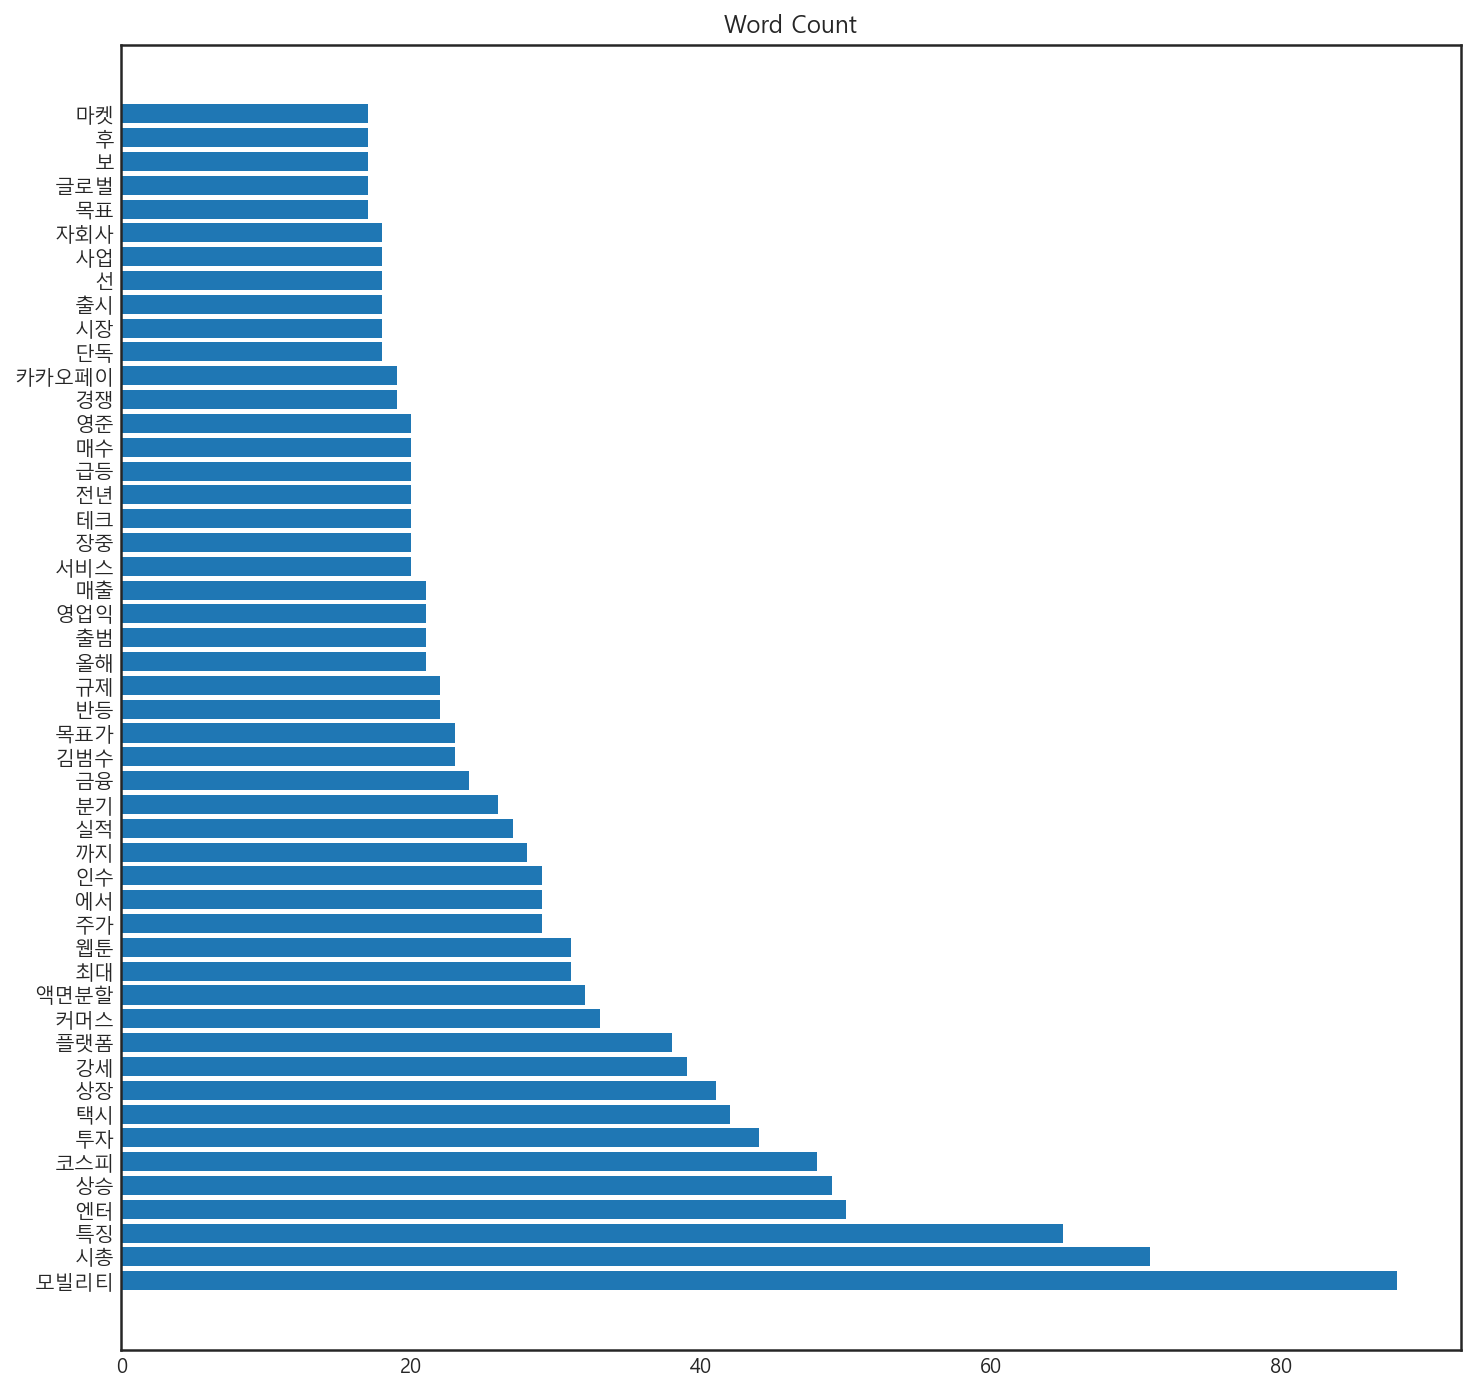

In [18]:
y_pos = np.arange(len(top_nouns))

plt.figure(figsize=(12, 12))
plt.barh(y_pos, top_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_nouns.keys())
plt.show()

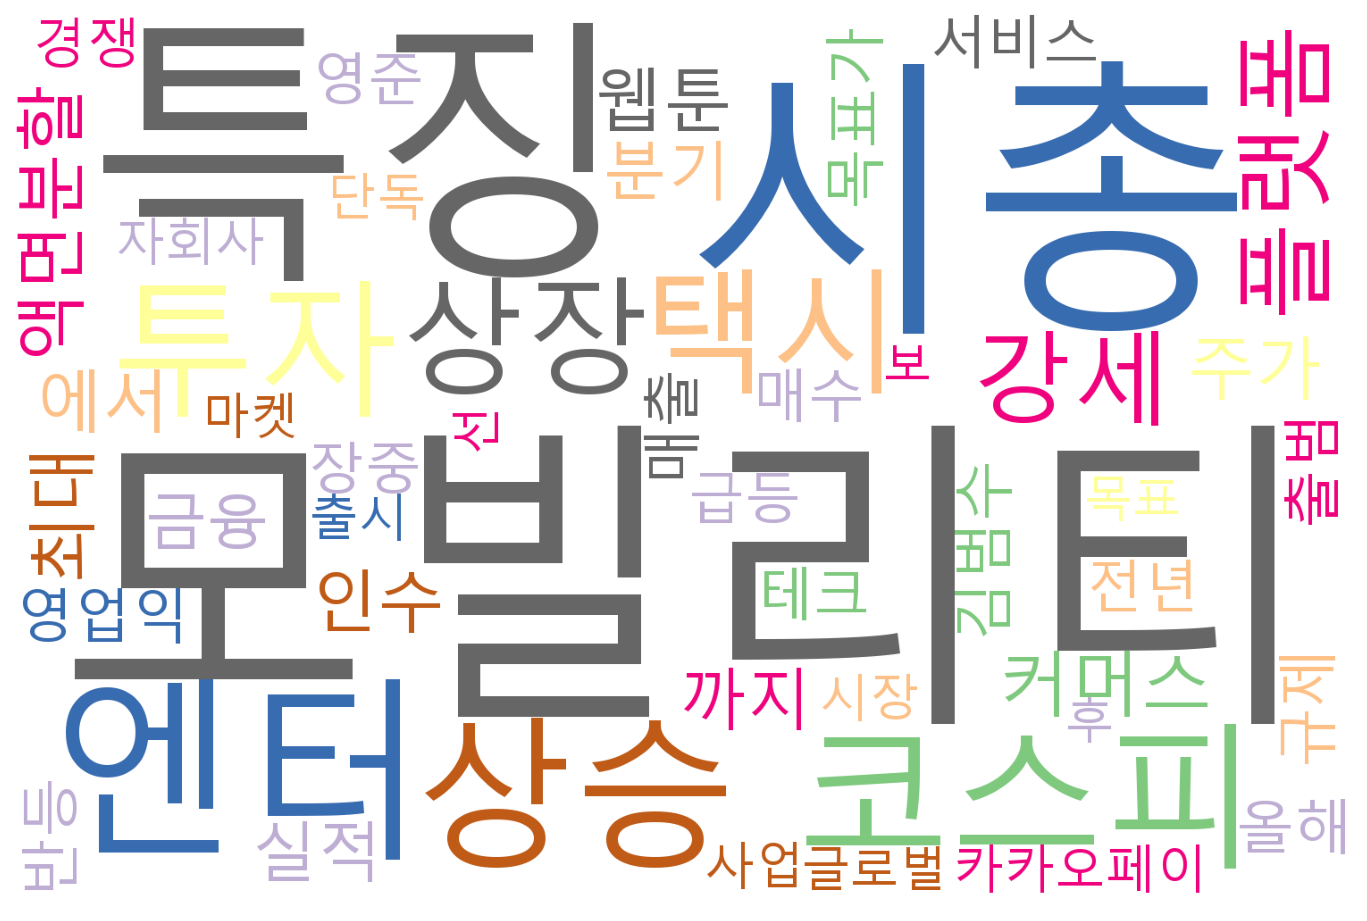

In [19]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", width=1500, height=1000)
wordcloud.generate_from_frequencies(top_nouns)

figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1, 1, 1)
ax.axis('off')
ax.imshow(wordcloud)
plt.show()


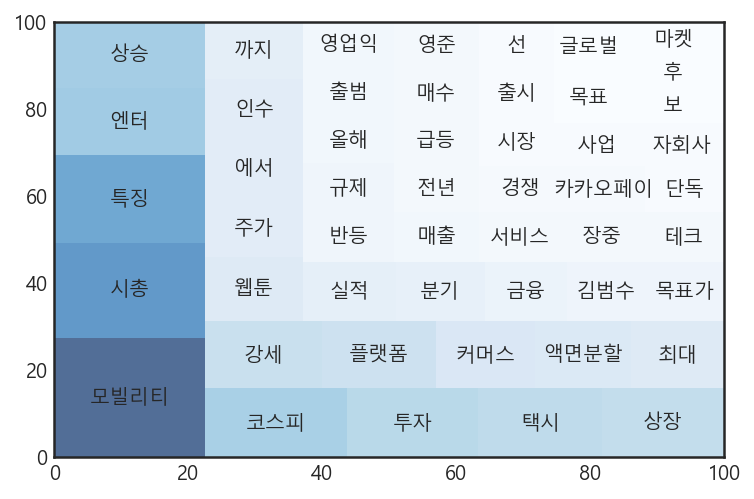

In [20]:
import squarify

norm = mpl.colors.Normalize(vmin=min(top_nouns.values()),
                            vmax=max(top_nouns.values()))

#top nouns의 값을 value로 가져와서 정규화
colors = [mpl.cm.Blues(norm(value)) for value in top_nouns.values()]

squarify.plot(label = top_nouns.keys(),
              sizes = top_nouns.values(),
              color=colors,
              alpha=0.7);

In [21]:
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)
        
    def call(self, inputs):
        return self.gpt2(inputs)[0]

In [22]:
#BASE_MODEL_PATH = './gpt_ckpt'
BASE_MODEL_PATH= '/nlp/gpt_ckpt/'
gpt_model = GPT2Model(BASE_MODEL_PATH)

In [23]:
tf.random.set_seed(111)
np.random.seed(111)

In [24]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

In [25]:
TOKENIZER_PATH = '/nlp/gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = '<unused0>',
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')

In [26]:
def clean_text(text):
    text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)
    
    return text_clean

In [27]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=99999):
    _logits = logits.numpy()
    top_k = min(top_k, logits.shape[-1])
    if top_k > 0:
        indices_to_remove = logits < tf.math_top_k(logits, top_k)[0][..., -1, None]
        _logits[indices_to_remove] = filter_value
        
    if top_p > 0:
        sorted_logits = tf.sort(logits, direction='DESCENDING')
        sorted_indices = tf.argsort(logits, direction='DESCENDING')
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis= -1)
        
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
        indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()
        
        _logits[indices_to_remove] = filter_value
        
    return tf.constant([_logits])

def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0.):
    sentence = seed_word
    toked = tokenizer(sentence)
    
    for _ in range(max_step):
        input_ids = tf.constant([vocab[vocab.bos_token], ] + vocab[toked])[None, :]
        outputs = model(input_ids)[:, -1, :]
        if greedy:
            gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
        else:
            output_logit =tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
            gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
        if gen == '</s>':
            break
            
        sentence += gen.replace('▁', ' ')
        toked = tokenizer(sentence)
        
    return sentence

In [28]:
train_data, test_data = train_test_split(analysis, test_size=0.25, shuffle=True)

In [29]:
train_data

,기사제목,up_down
2021-11-08,코스피 2960선 마감…'코스피 카카오 3형제' 시총 하루 만에 4.3...,0
2021-05-07,"1분기 역대 최고 실적 낸 '카카오'…목표주가↑""아직 볼 게 많다""",0
2021-06-18,"[특징주]시총 3위 굳히기 나선 카카오, 카카오뱅크 상장예비심사 통과...",1
2021-09-08,날벼락 맞은 네이버·카카오…플랫폼 금융 규제 소식에 주가 동반 급락,0
2021-11-04,"카카오, 3분기 영업익 1682억…전년비 39.9% ↑",1
...,...,...
2021-02-09,"[종합] 카카오, 톡비즈 날개 달고 영업익 4560억",1
2021-06-02,"카카오, 주 52시간 근무 위반 등 근로기준법 어겨",0
2021-02-08,"카카오, 119억 규모 자사주 처분 결정",1
2021-06-10,"금융위, 카카오손해보험 예비허가 의결…빅테크 첫 보험업 진출",1


In [30]:
train_data_sents = []
train_data_labels= []

for train_sent, train_label in train_data[['기사제목', 'up_down']].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]
    
    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([train_tokenized_text],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]
    
    train_data_sents.append(tokens)
    train_data_labels.append(train_label)
    
train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)


In [31]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class,
                                                kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                                name='classifier')
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:,-1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

In [32]:
BASE_MODEL_PATH= '/nlp/gpt_ckpt/'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [34]:
model_name= 'tf2_gpt2_naver_stock'
DATA_OUT_PATH = './data_out'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta= 0.0001, patience=2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} directory already exists\n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} directory create completed\n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path,
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only= True,
                              save_weights_only=True)
history = cls_model.fit(train_data_sents, train_data_labels,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

./data_out\tf2_gpt2_naver_stock directory already exists

Epoch 1/20
47/47 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.4963
Epoch 00001: val_accuracy improved from -inf to 0.45833, saving model to ./data_out\tf2_gpt2_naver_stock\weights.h5
47/47 [==============================] - 13s 107ms/step - loss: 0.6946 - accuracy: 0.4963 - val_loss: 0.6968 - val_accuracy: 0.4583
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5136
Epoch 00002: val_accuracy improved from 0.45833 to 0.51786, saving model to ./data_out\tf2_gpt2_naver_stock\weights.h5
47/47 [==============================] - 4s 81ms/step - loss: 0.6928 - accuracy: 0.5136 - val_loss: 0.6926 - val_accuracy: 0.5179
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5343
Epoch 00003: val_accuracy did not improve from 0.51786
47/47 [==============================] - 3s 71ms/step - loss: 0.6894 - accuracy: 0.5343 - val_loss: 0.7036 -

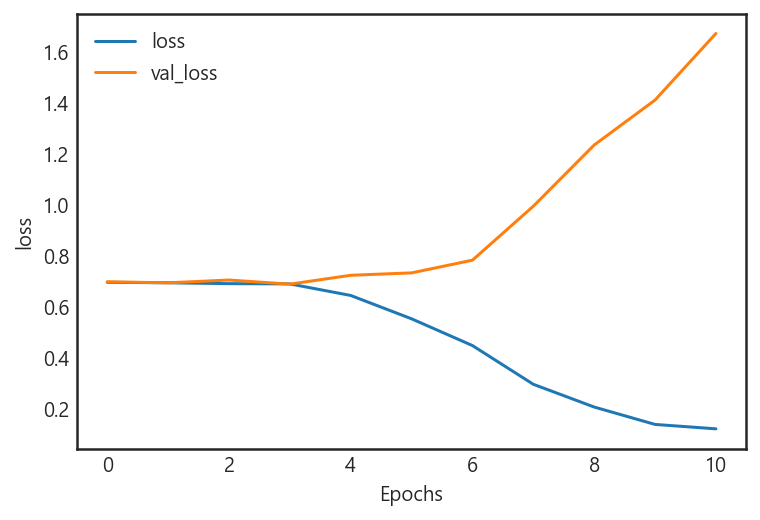

In [35]:
def plot_graphs_loss(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs_loss(history,'loss')

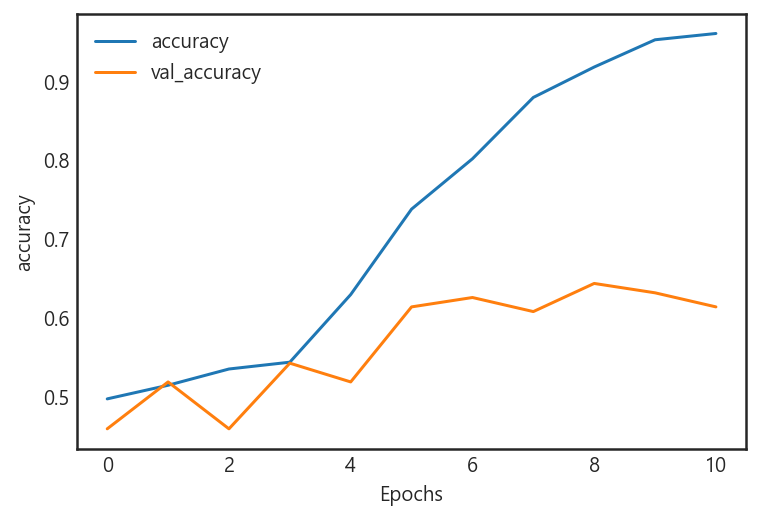

In [36]:
def plot_graphs_acc(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs_acc(history,'accuracy')

In [37]:
test_data_sents = []
test_data_labels= []

for test_sent, test_label in test_data[['기사제목', 'up_down']].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]
    
    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([test_tokenized_text],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens += [vocab[vocab.eos_token]]
    
    test_data_sents.append(tokens)
    test_data_labels.append(test_label)
    
test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [38]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents,test_data_labels, batch_size=32)

18/18 [==============================] - 0s 22ms/step - loss: 1.1314 - accuracy: 0.6523


[1.131391167640686, 0.6523297429084778]